In [4]:
using Distributions
using Random
using scBayesDeconv
using Plots
using MAT

In [27]:
fitca = matread("Data/Real_1_multichannel/20191030_FITCA.mat")
percp = matread("Data/Real_1_multichannel/20191030_PerCP-Cy5-5-A.mat")

Dict{String, Any} with 3 entries:
  "intensity"        => [244.53 306.9 … 293.04 203.94; 57.42 345.51 … 407.88 33…
  "Conditions"       => Any["20191030-1_Bra Act+Chi_P3" "20191030-1_Bra Act_P3"…
  "intensity_pulled" => [244.53 306.9 … 12.87 297.99; 57.42 345.51 … 297.0 97.0…

In [28]:
channel1 = fitca["intensity"][:,1]
channel1c = fitca["intensity"][:,7]
channel2 = percp["intensity"][:,1]
channel2c = percp["intensity"][:,7];

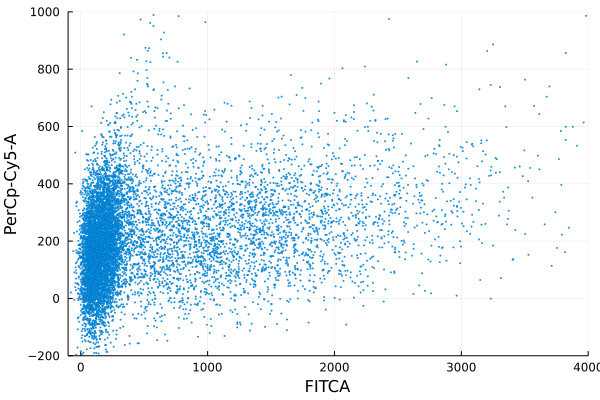

In [44]:
scatter(channel1,channel2,markersize=1,markerstrokewidth=0.1,xlabel="FITCA",ylabel="PerCp-Cy5-A",label="")
xlims!(-100,4000)
ylims!(-200,1000)

In [49]:
n = channel2[1:3000]
t = channel1[1:3000]
c = channel1c[1:3000]+channel2c[1:3000];

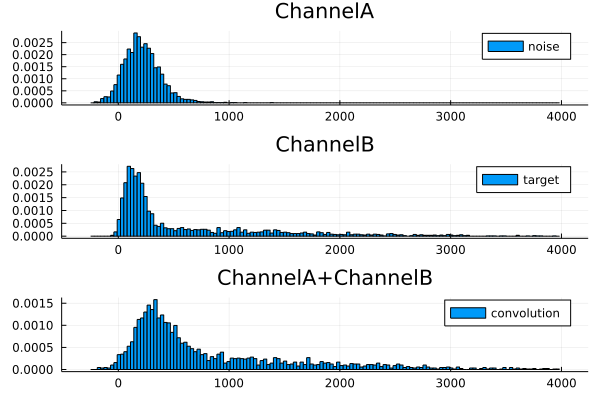

In [54]:
bins = range(-250,4000,step=30)
l1 = histogram(vec(n),normalize=true,bins=bins,label="noise",title="ChannelA")

bins = range(-250,4000,step=30)
l2 = histogram(vec(t),normalize=true,bins=bins,label="target",title="ChannelB")

bins = range(-250,4000,step=30)
l3 = histogram(vec(c),normalize=true,bins=bins,label="convolution",title="ChannelA+ChannelB")

plot(l1,l2,l3,layout=(3,1))

In [56]:
dn = infiniteGaussianMixture(reshape(n,length(n),1),k=2,Σ0 = ones(1,1),κ0=0.01);

In [59]:
dtfitted = infiniteGaussianMixture(reshape(t,length(t),1),k=2,Σ0 = ones(1,1),κ0=0.01);

In [97]:
dc = infiniteGaussianMixture(reshape(c,length(c),1),k=2,Σ0 = ones(1,1),κ0=0.01);

In [57]:
dt = infiniteGaussianMixtureDeconvolution(reshape(c,length(c),1),dn,k=1,Σ0=ones(1,1),κ0=0.01,ν0=0.01,α=1);

In [100]:
x = -200:10:5000
bins = range(-250,4000,step=30)

#Noise
miae = []
for k in 2:10:100
    f1(x) = pdf(dn.samples[k],x)
    f2(x) = pdf(dt.samples[k],x)
    push!(miae, scBayesDeconv.metrics.MIAE(f1,f2,[-250. 4000.],.5))
end

l1 = histogram(vec(n),normalize=true,bins=bins,label="noise",title="ChannelA")

for k in 2:1:100
    y = ([pdf(dn.samples[k],[j]) for j in x])
    plot!(l1,x,y,style=:dash,label=nothing,title=string("Noise"))
end

#Target
miae = []
for k in 2:10:100
    f1(x) = pdf(dtfitted.samples[k],x)
    f2(x) = pdf(dt.samples[k],x)
    push!(miae, scBayesDeconv.metrics.MIAE(f1,f2,[-250. 4000.],.5))
end

bins = range(-250,4000,step=30)
l2 = histogram(vec(t),normalize=true,bins=bins,label="target",title="ChannelB")

for k in 2:1:100
    y = ([pdf(dt.samples[k],[j]) for j in x])
    plot!(l2,x,y,style=:dash,label=nothing,title=string("Target MIO:",round(mean(miae),digits=3)))
end

#Convolution
miae = []
for k in 2:10:100
    f1(x) = pdf(dc.samples[k],x)
    f2(x) = pdf(dt.samples[k],x)
    push!(miae, scBayesDeconv.metrics.MIAE(f1,f2,[-250. 4000.],.5))
end

bins = range(-250,4000,step=30)
l3 = histogram(vec(c),normalize=true,bins=bins,label="convolution",title=string("ChannelA+ChannelB MIO:",mean(miae)))

plot(l1,l2,l3,layout=(3,1),size=[2000,1000])